# Column generation and vehicle routing

In [23]:
using Plots, Random, LinearAlgebra, Printf, JLD, Distributions, Combinatorics, Graphs

In [24]:
using JuMP, Gurobi

const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18


Gurobi.Env(Ptr{Nothing} @0x000000016cf9ea00, false, 0)

## 0: Data loading

In [25]:
struct VehicleRoutingData
    capacity::Int
    num_vehicles::Int
    num_customers::Int
    distances::Matrix{Float64}
    locations::Matrix{Float64}
    demand::Vector{Int}
end

In [26]:
data = load("data.jld", "data")

VehicleRoutingData(15, 4, 10, [0.0 60.44968914682852 … 42.89222233592312 35.78340032043964; 60.44968914682852 0.0 … 30.032109551235603 51.972824841022586; … ; 42.89222233592312 30.032109551235603 … 0.0 22.258706274747677; 35.78340032043964 51.972824841022586 … 22.258706274747677 0.0], [80.61200406224276 31.4701066979307; 80.72318033076978 91.91969360955082; … ; 60.75394537170522 69.48852646989688; 50.0 50.0], [5, 3, 4, 9, 4, 5, 4, 6, 5, 3])

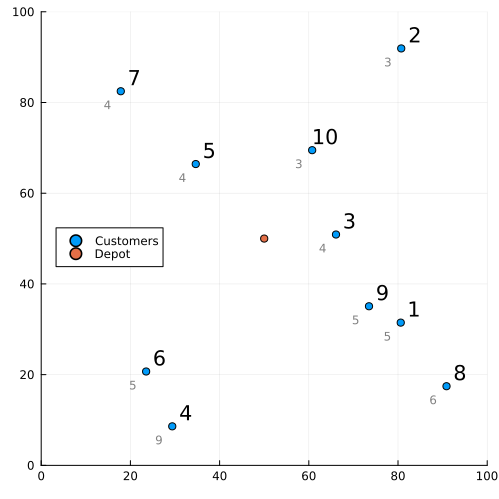

In [27]:
function plot_from_data(
    data::VehicleRoutingData,
)
    """Given a problem instance, plot it.
    """
    N = data.num_customers
    pl = plot(
        size = (500,500), 
        xlim = (0, 100), 
        ylim = (0, 100),
    )
    for i in 1:N
        annotate!(
            data.locations[i,1] + 3, 
            data.locations[i,2] + 3, 
            text("$i")
        )
        annotate!(
            data.locations[i,1] - 3, 
            data.locations[i,2] - 3, 
            text("$(data.demand[i])", :gray, 8),
        )
    end
    scatter!(
        data.locations[1:N, 1], 
        data.locations[1:N, 2], 
        label = "Customers",
    )
    scatter!(
        data.locations[[N+1], 1], 
        data.locations[[N+1], 2], 
        label = "Depot"
    )
    scatter!(
        legend = :left,
    )
    return pl
end
plot_from_data(data)

## 1: Direct solve

Here, we solve Formulation (1) directly.

In [28]:
function direct_solve(
    data::VehicleRoutingData,
    ;
    time_limit::Int = 300,
)
    """Solves the problem directly, using Formulation (1);
    Use this function to debug your solution.
    """
    
    K = data.num_vehicles
    N = data.num_customers

    model = Model(Gurobi.Optimizer)
    set_time_limit_sec(model, time_limit)
    @variable(model, y[1:N+1,1:N+1,1:K], Bin)
    @variable(model, z[1:N,1:K], Bin)
    

    @constraint(
        model, 
        [k in 1:K],
        sum(y[N+1,j,k] for j in 1:N+1) == 1
    )
    @constraint(
        model, 
        [i in 1:N+1, k in 1:K],
        y[i,i,k] == 0
    )
    @constraint(
        model, 
        [i in 1:N+1, k in 1:K],
        sum(y[i,j,k] for j in 1:N+1) 
        == sum(y[j,i,k] for j in 1:N+1) 
    )
    @constraint(
        model,
        [i in 1:N+1, k in 1:K],
        sum(y[i,j,k] for j in 1:N+1) 
        ≤ 1
    )
    for S in combinations(1:N)
        @constraint(
            model,
            [k in 1:K],
            sum(y[i,j,k] for i in S, j in S) ≤ length(S) - 1
        )
    end
    @constraint(
        model, 
        [i = 1:N, k in 1:K],
        z[i,k] == sum(y[i,j,k] for j in 1:N+1)
    )
    @constraint(
        model,
        [i in 1:N],
        sum(z[i,k] for k in 1:K) == 1
    )
    @constraint(
        model, 
        [k in 1:K],
        sum(data.demand[i] * z[i,k] for i in 1:N) ≤ data.capacity
    )
    @objective(
        model,
        Min,
        sum(data.distances[i,j] * y[i,j,k] for i in 1:N+1, j in 1:N+1, k in 1:K)
    )
    
    time_taken = @elapsed optimize!(model)

    return Dict(
        "y" => value.(y),
        "z" => value.(z),
        "time" => time_taken,
        "objective" => objective_value(model),
    )
end

direct_solve (generic function with 1 method)

In [29]:
direct_solution = direct_solve(data);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4282 rows, 524 columns and 114652 nonzeros
Model fingerprint: 0xdb2bb9c1
Variable types: 0 continuous, 524 integer (524 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [8e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 138 rows and 54 columns
Presolve time: 0.06s
Presolved: 4144 rows, 470 columns, 93560 nonzeros
Variable types: 0 continuous, 470 integer (470 binary)
Found heuristic solution: objective 617.1762183

Root relaxation: objective 3.444784e+02, 98 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Boun

## 2: Utilities

We provide here a utility function `find_subtours()` that finds subtours in a given route solution.

In [30]:
function find_subtours(
    N::Int,
    sol::Array{Float64, 2},
)
    """
    Given a solution (provided as a N+1 by N+1 array,
    with `sol[i,j] == 1.0` whenever the arc `i->j` is in the route),
    produces a list of components (as a Vector{Vector{Int}}) 
    where each component consists of the nodes that are "connected".
    """
    @assert size(sol) == (N+1, N+1)
    g = DiGraph(N+1)
    for ind in findall(x -> (x > 0.5), sol)
        add_edge!(g, ind[1], ind[2])
    end
    components = strongly_connected_components(g)

    ind = findfirst(x -> (N+1 in x), components)
    subtour = popat!(components, ind)
    i = findfirst(x -> x == N+1, subtour)
    new_subtour = vcat(subtour[i:end], subtour[1:i-1])
    insert!(components, 1, new_subtour)

    return components
end

find_subtours (generic function with 1 method)

Here is a utility function `plot_from_solution()` that plots a integral solution to the direct formulation visually.

In [31]:
function plot_from_solution(
    data::VehicleRoutingData,
    y::Array{Float64, 3},
)
    """Given a problem instance and a corresponding (Formulation 1) solution, plot it.
    """
    N = data.num_customers
    K = data.num_vehicles
    pl = plot_from_data(data)
    for k in 1:K
        nodes = find_subtours(N, y[:,:,k])[1]
        push!(nodes, N+1)
        plot!(
            data.locations[nodes, 1],
            data.locations[nodes, 2],
            label = "Vehicle $k",
        )
    end
    return pl
end

plot_from_solution (generic function with 1 method)

Let's visualize the solution obtained via the direct formulation!

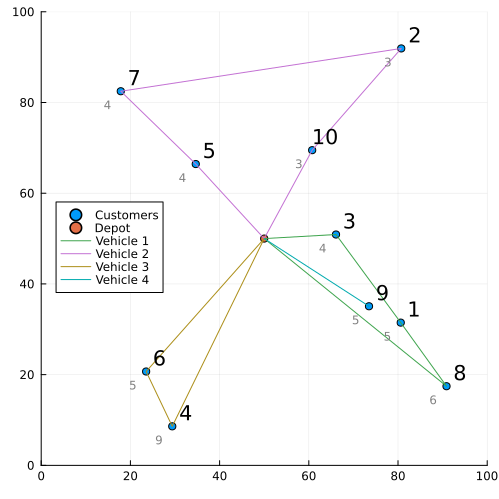

In [32]:
plot_from_solution(data, direct_solution["y"])

## 3: Column generation

Here is some code to get you started. We define a route as a struct (a Julia object) with the following attributes: `arcs` (a vector of its arcs, each being a tuple of nodes), `cost` (its cost), and `customers` (a vector of nodes corresponding to customers it visits).

In [33]:
struct Route
    arcs::Vector{Tuple{Int,Int}}
    cost::Float64
    customers::Vector{Int}
end

Q: Given a route, how would you compute its cost?

In [34]:
function compute_route_cost(
    data::VehicleRoutingData,
    arcs::Vector{Tuple{Int,Int}},
)
    """
    Computes the cost of a route, given its sequence of arcs.
    (TODO)
    """
    return sum(data.distances[arc[1],arc[2]] for arc in arcs)
end

compute_route_cost (generic function with 1 method)

We first implement a heuristic way of finding initial feasible routes. Here they only need to be feasible (satisfying each vehicle's capacity constraint) and the routes are in general far from optimal.

In [35]:
function initial_routes(
    data::VehicleRoutingData
    ;
)
    """
    Given a problem instance, generates a feasible set of routes.
    These routes are generated such that they satisfy the capacity constraint,
    but need not be "cheap".
    """
    N = data.num_customers
    Q = data.capacity
    # Iterates until termination
    while true 
        # Performs a random shuffle of the customers
        shuffled_indices = randperm(data.num_customers)
        arcs = Tuple{Int,Int}[]
        all_arcs = Vector{Tuple{Int,Int}}[]
        current = N+1
        total = 0
        # Greedily add customers to each route until capacity is violated, 
        # start a new route if capacity is about to be violated.
        for c in shuffled_indices
            d = data.demand[c]
            if total + d > Q
                push!(arcs, (current, N+1))
                push!(all_arcs, arcs)
                arcs = []
                total = 0
                current = N+1
            end
            total += d
            push!(arcs, (current, c))
            current = c
        end
        push!(arcs, (current, N+1))
        push!(all_arcs, arcs)
        # Check if the total number of routes generated is ≤ K
        if length(all_arcs) ≤ data.num_vehicles
            return [
                Route(
                    arcs,
                    compute_route_cost(data, arcs),
                    [x[2] for x in arcs[1:end-1]],
                )
                for arcs in all_arcs
            ]
        end
    end
end

initial_routes (generic function with 1 method)

We implement this in the function `new_route()` below. Note that we had to use lazy callbacks to deal with the exponential number of subtour elimination constraints in the formulation. **This function is incomplete: please fill in the rest of the function.**

In [36]:
function compute_route_reduced_cost(
    data::VehicleRoutingData,
    route::Route,
    p::Vector{Float64}, 
    q::Float64,
)
    """
    Computes reduced cost of a route according to dual variables p and q.
    (TODO)
    """
    N = data.num_customers
    
    if length(route.customers)>0
        return compute_route_cost(data, route.arcs) - sum(p[i] for i in 1:N if i in route.customers) - q
    else
        return compute_route_cost(data, route.arcs) - q
    end
end

compute_route_reduced_cost (generic function with 1 method)

In [37]:
function new_route(
    data::VehicleRoutingData,
    p::Vector{Float64},
    q::Float64,
)
    """
    Given dual variables p and q, 
    find a new route to add with minimum reduced cost.
    (TODO)
    """

    N = data.num_customers
    Q = data.capacity
    
    """
    (TODO)
    """
    # Compute modified costs
    modified_costs = copy(data.distances)
    modified_costs[N+1, :] = modified_costs[N+1, :] .- q 
    for i in 1:N
        modified_costs[i,:] = modified_costs[i,:] .- p[i]
    end

    # Create subproblem model
    subproblem = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        subproblem,
        "OutputFlag" => 0,
    )
    # Constraints
    """
    (TODO)
    """
    @variable(subproblem, y[i in 1:N+1, j in 1:N+1], Bin)
    @variable(subproblem, z[i in 1:N], Bin)
    @constraint(subproblem, sum(y[N+1,:])==1)
    
    @constraint(subproblem, [i=1:N], y[i,i]==0) 
    @constraint(subproblem, [i=1:N+1], sum(y[i,:])==sum(y[:,i])) 
    @constraint(subproblem, [i=1:N+1], sum(y[i,:])<=1) 
    @constraint(subproblem, [i=1:N], z[i]==sum(y[i,:])) 
    @constraint(subproblem, sum(data.demand .* z) <= Q)

    # Objective
    @objective(subproblem, Min, sum(modified_costs[i,j] * y[i,j] for i in 1:N+1 for j in 1:N+1))

    # Callback function to eliminate subtours
    # Uses the helper function `find_subtours`.
    function eliminate_subtours(cb_data)
        status = callback_node_status(cb_data, subproblem)
        if status == MOI.CALLBACK_NODE_STATUS_FRACTIONAL
            return
        elseif status == MOI.CALLBACK_NODE_STATUS_INTEGER
            sol = callback_value.(cb_data, y)
            subtours = find_subtours(N, sol)
            for subtour in subtours
                if length(subtour) == 1 || N+1 in subtour
                    continue
                else
                    cut = @build_constraint(
                        sum(y[i,j] for i in subtour, j in subtour)
                        ≤ length(subtour) - 1
                    )
                    MOI.submit(subproblem, MOI.LazyConstraint(cb_data), cut)
                end
            end
        end
    end
    MOI.set(subproblem, MOI.LazyConstraintCallback(), eliminate_subtours)

    optimize!(subproblem)

    # Compute route and reduced cost from solution
    """
    (TODO)
    """
    sol = value.(y)
    nodes = [N+1]
    push!(nodes, argmax(sol[nodes[end],:])) 
    while nodes[end] != N+1
        push!(nodes, argmax(sol[nodes[end],:]))
    end
    arcs = collect(zip(nodes[1:end-1], nodes[2:end])) 
    cost = compute_route_cost(data, arcs)
    customers = nodes[2:end-1]

    route = Route(
        arcs,
        cost,
        customers,
    )
    reduced_cost = compute_route_reduced_cost(data, route, p, q)

    return route, reduced_cost

end

new_route (generic function with 1 method)

We now implement the overall algorithm. **This function is incomplete: please fill in the rest of the function.**

In [38]:
function cvrp_column_generation(
    data::VehicleRoutingData,
    ;
    max_iterations::Int = 10000,
    verbose::Bool = true,
)
    """
    Column generation algorithm for the VRP.
    (TODO)
    """
    N = data.num_customers
    K = data.num_vehicles

    # Initialization
    CGLP_solution = nothing
    CGLP_objective = 0.0
    upper_bounds = []
    lower_bounds = []
    MP_time = []
    SP_time = []
    p_values = []
    q_values = []

    if verbose
        @printf("              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost\n")
    end

    # Creates initial routes
    routes = initial_routes(data)
    counter = 0

    while true
        counter += 1

        # Make restricted master problem with current routes 
        MP_start_time = time()
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )

        """
        (TODO: Constraints and objective (over routes))
        """
        @variable(model, x[r in 1:length(routes)] >= 0)

        @constraint(model, visit_customer[i in 1:N], sum(x[r] for r in 1:length(routes)if i in routes[r].customers ) == 1)
        @constraint(model, capacity, sum(x[r] for r in 1:length(routes)) <= K)
        
        @objective(model, Min, sum(x[r] * routes[r].cost for r in 1:length(routes)))

        optimize!(model)
        MP_end_time = time()

        """
        (TODO: get duals)
        """
        p = dual.(visit_customer)
        q = dual.(capacity)
        push!(p_values, p)
        push!(q_values, q)

        # Update column generation metrics
        upper_bound = objective_value(model) # TODO
        push!(upper_bounds, upper_bound)
        push!(MP_time, MP_end_time - MP_start_time)

        # Compute a new route to add and its corresponding reduced cost
        SP_start_time = time()
        """
        (TODO: solve subproblem)
        """
        route, reduced_cost = new_route(data, p, q) # TODO
        SP_end_time = time()

        # Update column generation metrics
        lower_bound = objective_value(model) + K*reduced_cost # TODO
        push!(lower_bounds, lower_bound)
        push!(SP_time, SP_end_time - SP_start_time)

        if verbose
            # @printf("              | Objective | MP time (s) | SP time (s) | Reduced cost")
            @printf(
                "Iteration %3d | %9.3f | %11.3f |      %6.3f |      %6.3f | %12.3f\n",
                counter, 
                upper_bound,
                lower_bound,
                MP_time[end],
                SP_time[end],
                reduced_cost,
            )
            flush(stdout)
        end

        # Termination criteria
        if (
            reduced_cost > -1e-6
            || counter > max_iterations
        )  
            CGLP_solution = value.(x) # TODO
            CGLP_objective = objective_value(model) # TODO
            break
        end
        push!(routes, route)
    end

    """
    (TODO) Solve model again with the same variables, enforcing integrality
    """
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(model,"OutputFlag" => 0,)
    
    @variable(model, x[r in 1:length(routes)], Bin)
    
    @constraint(model, visit_customer[i in 1:N], sum(x[r] for r in 1:length(routes) if i in routes[r].customers ) == 1)
    @constraint(model, capacity, sum(x[r] for r in 1:length(routes)) <= K)
    
    @objective(model, Min, sum(x[r] * routes[r].cost for r in 1:length(routes)))

    optimize!(model)

    CGIP_solution = value.(x) # TODO
    CGIP_objective = objective_value(model) # TODO
    
    return Dict(
        "CGIP_solution" => CGIP_solution,
        "CGIP_objective" => CGIP_objective,
        "CGLP_solution" => CGLP_solution,
        "CGLP_objective" => CGLP_objective,
        "routes" => routes,
        "p_values" => p_values,
        "q_values" => q_values,
        "upper_bounds" => upper_bounds,
        "lower_bounds" => lower_bounds,
        "MP_time" => MP_time,
        "SP_time" => SP_time,
        "time_taken" => sum(MP_time) + sum(SP_time),
    )
end

cvrp_column_generation (generic function with 1 method)

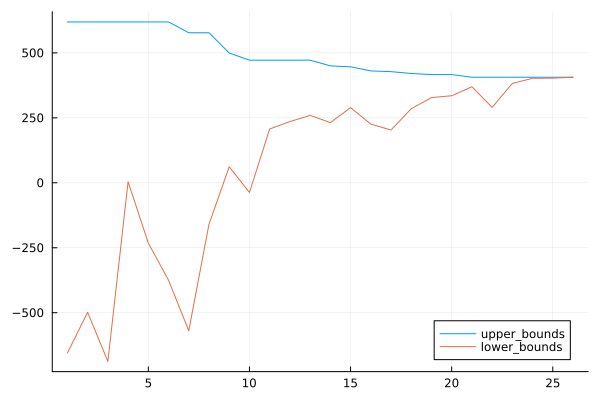

In [73]:
plot(
    cg_solution["upper_bounds"],
    label = "upper_bounds",
)
plot!(
    cg_solution["lower_bounds"],
    label = "lower_bounds",
)


In [ ]:
plot(
    cg_solution["MP_time"],
    label = "mp_time",
)
plot!(
    cg_solution["SP_time"],
    label = "sp_time",
)


In [51]:
plot(cg_solution[  "SP_time"])

function plot_from_route_solution(
    data::VehicleRoutingData,
    routes::Vector{Route},
    solution::Vector{Float64},
)
    """Given a problem instance and a corresponding route solution, plot it.
    """
    N = data.num_customers
    pl = plot_from_data(data)
    k = 0
    for (route, val) in zip(routes, solution)
        if val == 0.0
            continue
        end
        k += 1
        nodes = [arc[1] for arc in route.arcs]
        push!(nodes, N+1)
        plot!(
            data.locations[nodes, 1],
            data.locations[nodes, 2],
            label = "Vehicle $k: $val",
        )
    end
    plot!(title = "Column generation solution")
    return pl
end


plot_from_route_solution (generic function with 1 method)

In [39]:
cg_solution = cvrp_column_generation(data, verbose = true);

              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost
Iteration   1 |   618.858 |    -654.941 |       0.232 |       0.304 |     -318.450


Iteration   2 |   618.858 |    -498.398 |       0.001 |       0.004 |     -279.314


Iteration   3 |   618.858 |    -687.584 |       0.000 |       0.003 |     -326.611


Iteration   4 |   618.858 |       3.969 |       0.000 |       0.008 |     -153.722


Iteration   5 |   618.858 |    -232.131 |       0.001 |       0.017 |     -212.747


Iteration   6 |   618.858 |    -374.930 |       0.000 |       0.004 |     -248.447


Iteration   7 |   577.451 |    -569.462 |       0.000 |       0.004 |     -286.728


Iteration   8 |   577.451 |    -159.351 |       0.000 |       0.012 |     -184.200


Iteration   9 |   499.330 |      61.577 |       0.000 |       0.010 |     -109.438


Iteration  10 |   471.971 |     -37.337 |       0.000 |       0.009 |     -127.327


Iteration  11 |   471.971 |     207.079 |       0.000 |       0.031 |      -66.223


Iteration  12 |   471.971 |     235.627 |       0.000 |       0.030 |      -59.086


Iteration  13 |   471.971 |     259.478 |       0.001 |       0.038 |      -53.123


Iteration  14 |   449.979 |     231.556 |       0.001 |       0.018 |      -54.606


Iteration  15 |   446.339 |     289.230 |       0.001 |       0.018 |      -39.277


Iteration  16 |   430.628 |     225.926 |       0.000 |       0.024 |      -51.176


Iteration  17 |   427.739 |     203.105 |       0.000 |       0.030 |      -56.159


Iteration  18 |   420.719 |     285.026 |       0.001 |       0.041 |      -33.923


Iteration  19 |   416.479 |     327.915 |       0.001 |       0.023 |      -22.141


Iteration  20 |   416.479 |     334.950 |       0.001 |       0.017 |      -20.382


Iteration  21 |   406.288 |     369.653 |       0.001 |       0.027 |       -9.159


Iteration  22 |   406.288 |     290.208 |       0.000 |       0.023 |      -29.020


Iteration  23 |   406.288 |     382.584 |       0.001 |       0.030 |       -5.926


Iteration  24 |   406.288 |     402.322 |       0.001 |       0.023 |       -0.992


Iteration  25 |   406.288 |     402.662 |       0.001 |       0.028 |       -0.907


Iteration  26 |   406.288 |     406.288 |       0.001 |       0.046 |        0.000


In [40]:
println("Objective value (fractional):  $(cg_solution["CGLP_objective"])")
println("Objective value (integer):     $(cg_solution["CGIP_objective"])")
println("Time taken:                    $(cg_solution["time_taken"])")

Objective value (fractional):  406.28780346169646
Objective value (integer):     494.85586370023003
Time taken:                    1.0666487216949463


Use these functions to plot your solution.

In [41]:
function plot_from_route_solution(
    data::VehicleRoutingData,
    routes::Vector{Route},
    solution::Vector{Float64},
)
    """Given a problem instance and a corresponding route solution, plot it.
    """
    N = data.num_customers
    K = data.num_vehicles
    pl = plot_from_data(data)
    k = 0
    for (route, val) in zip(routes, solution)
        if val == 0.0
            continue
        end
        k += 1
        nodes = [arc[1] for arc in route.arcs]
        push!(nodes, N+1)
        plot!(
            data.locations[nodes, 1],
            data.locations[nodes, 2],
            label = "Vehicle $k: $val",
        )
    end
    plot!(title = "Column generation solution")
    return pl
end

plot_from_route_solution (generic function with 1 method)

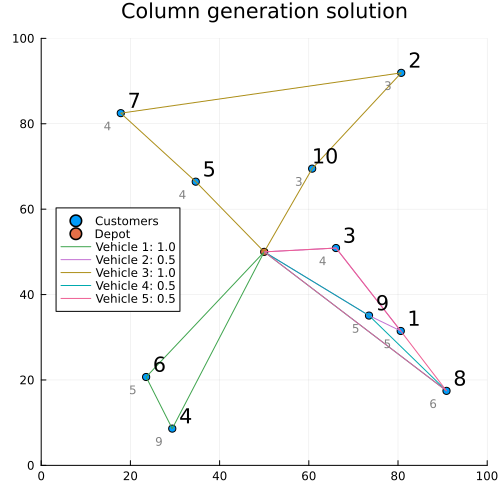

In [42]:
plot_from_route_solution(
    data,
    cg_solution["routes"],
    cg_solution["CGLP_solution"],
)

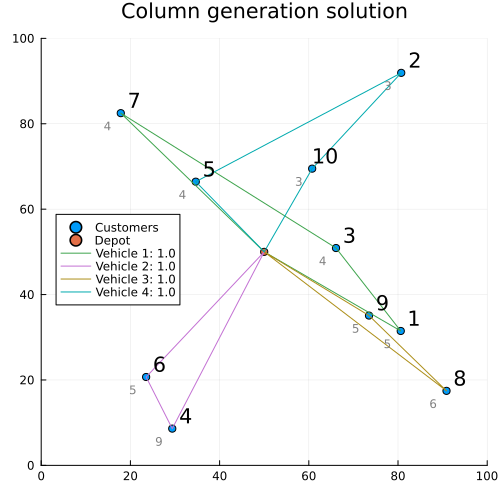

In [43]:
plot_from_route_solution(
    data,
    cg_solution["routes"],
    cg_solution["CGIP_solution"],
)

In [76]:
data.K

ErrorException: type VehicleRoutingData has no field K

In [74]:
cg_solution["routes"]

29-element Vector{Route}:
 Route([(11, 10), (10, 4), (4, 11)], 136.99416745065713, [10, 4])
 Route([(11, 9), (9, 1), (1, 2), (2, 11)], 148.23481244595854, [9, 1, 2])
 Route([(11, 5), (5, 6), (6, 3), (3, 11)], 137.87606257109357, [5, 6, 3])
 Route([(11, 8), (8, 7), (7, 11)], 195.75335655278838, [8, 7])
 Route([(11, 7), (7, 3), (3, 1), (1, 11)], 163.41440519170783, [7, 3, 1])
 Route([(11, 5), (5, 2), (2, 8), (8, 11)], 202.55004951620464, [5, 2, 8])
 Route([(11, 7), (7, 6), (6, 9), (9, 11)], 187.59251916822086, [7, 6, 9])
 Route([(11, 4), (4, 6), (6, 11)], 99.17163537565187, [4, 6])
 Route([(11, 10), (10, 1), (1, 8), (8, 11)], 134.78101910616422, [10, 1, 8])
 Route([(11, 9), (9, 8), (8, 3), (3, 11)], 110.33713766818457, [9, 8, 3])
 ⋮
 Route([(11, 7), (7, 1), (1, 8), (8, 11)], 196.22267932590773, [7, 1, 8])
 Route([(11, 2), (2, 8), (8, 1), (1, 11)], 180.29393024269535, [2, 8, 1])
 Route([(11, 9), (9, 8), (8, 11)], 104.84306133855411, [9, 8])
 Route([(11, 8), (8, 1), (1, 3), (3, 11)], 110.0

In [75]:
cg_solution["CGIP_solution"]

29-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0